In [1]:
import csv
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import re

In [2]:
#Reading Data

sentences=[]
labels=[]

with open('final_data.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    for datum in data:
        sentences.append(re.sub(r'[^\w\s]','',datum[0]).lower())
        labels.append(datum[1])
  
division_factor = len(sentences) * 50 // 100
    
# Sanity check
print(division_factor)
print(len(sentences))
print(len(labels))

12900
25800
25800


In [3]:
# --------------------------------------------------------------------
# tokenizing + one-hot encoding on the word level --------------------
# --------------------------------------------------------------------
from keras.preprocessing.text import text_to_word_sequence

print("Tokenizing...")
tokenized_sentences=[text_to_word_sequence(sentence) for sentence in sentences]
print("Done.")

# --------------------------------------------------------------------
# Building a dictionary ----------------------------------------------
# --------------------------------------------------------------------

print("Building a dictionary...")

#build a token_frequency dictionary
token_freq={}
for sentence in sentences:
    for word in sentence.split():
        if word not in token_freq:
            token_freq[word] = 1
        else:
            token_freq[word] +=1

# sort the tokens by value(frequency) and get a list of tuples
sorted_token_freq = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)

# get the 0'th element from each tuple -which is the token- and get rid of the frequency value
# limited by the vocabulary size
vocabulary_size=5000

index_to_word=[]
for i in range(vocabulary_size):
    index_to_word.append(sorted_token_freq[i][0])
print("%d Unique vocabulary has been added" % len(index_to_word))

sentence_padding_token = "<PAD>"
sentence_start_token = "<START>"
sentence_unknown_token = "<UNK>"

# inserting tokens <PAD>, <START>, <UNK> 
index_to_word.insert(0,sentence_unknown_token)
index_to_word.insert(0,sentence_start_token)
index_to_word.insert(0,sentence_padding_token)

# bulding a word to index dictionary

word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])
vocabulary_size += 3
print("Using vocabulary size %d." % vocabulary_size)

# adding start token to each sentence. Required for keras
for sent in tokenized_sentences: 
    sent.insert(0,sentence_start_token)
          
# Substituting Unknown Vocab with an unknown Token
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else sentence_unknown_token for w in sent]
    
print("Tokenized sentence example %s" %tokenized_sentences[0])


Using TensorFlow backend.


Tokenizing...
Done.
Building a dictionary...
5000 Unique vocabulary has been added
Using vocabulary size 5003.
Tokenized sentence example ['<START>', 'gayet', 'gã¼zel', 'bir', 'ã¼rã¼n', 'ama', 'keåÿke', 'daha', 'ucuz', 'olsa', 'kã¼ãã¼k', '<UNK>', 'daha', 'bã¼yã¼k', '<UNK>', 'ihtiyacä', 'olmuyor', 'kã¼ãã¼k', 'yazäcä', 'kullanänca', 'da', 'kartuåÿ', 'biraz', '<UNK>', 'oluyor', 'ama', 'ã¼rã¼n', 'gã¼zel']


In [4]:
# ---------------------------------------------------------------------------------------
# Create the training data --------------------------------------------------------------
# ---------------------------------------------------------------------------------------
print("Creating datasets...")
# one-hot encoding
def vectorize_sequences(sequences, dimension=vocabulary_size):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# converting to indices
X_temp = np.asarray([[word_to_index[w] for w in sent] for sent in tokenized_sentences])

data = vectorize_sequences(X_temp)

# shuffling data
unison_data = list(zip(data,labels))
random.shuffle(unison_data)
data, lbls = zip(*unison_data)

division_factor = len(data) * 50//100

# Splitting data
x_train, x_test = np.asarray(data[ : division_factor]).astype('float32'), np.asarray(data[division_factor : ]).astype('float32') # 50, 50
y_train ,y_test = np.asarray(lbls[ : division_factor]).astype('float32'), np.asarray(lbls[division_factor : ]).astype('float32') # 50, 50

# Sanity checks
print("\ncheck shapes ----------")
print("shape of X_train[0] " + str(x_train[0].shape))
print("shape of X_test " + str(x_test.shape))
print("shape of Y_train " + str(y_train.shape))
print("shape of Y_test " + str(y_test.shape))
print("Done.")


Creating datasets...

check shapes ----------
shape of X_train[0] (5003,)
shape of X_test (12900, 5003)
shape of Y_train (12900,)
shape of Y_test (12900,)
Done.


In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(8, activation='relu', input_shape=(vocabulary_size,)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 40032     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,041
Trainable params: 40,041
Non-trainable params: 0
_________________________________________________________________


In [11]:
division_factor = len(x_test)*50//100
x_val = x_test[:division_factor]
y_val = y_test[:division_factor]

final_x_test = x_test[division_factor:]
final_y_test = y_test[division_factor:]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Train on 12900 samples, validate on 6450 samples
Epoch 1/15
12900/12900 [==============================] - 1s 76us/step - loss: 0.5370 - acc: 0.8415 - val_loss: 0.4270 - val_acc: 0.8783
Epoch 2/15
12900/12900 [==============================] - 1s 49us/step - loss: 0.3463 - acc: 0.9047 - val_loss: 0.3262 - val_acc: 0.8895
Epoch 3/15
12900/12900 [==============================] - 1s 52us/step - loss: 0.2649 - acc: 0.9175 - val_loss: 0.2867 - val_acc: 0.8950
Epoch 4/15
12900/12900 [==============================] - 1s 58us/step - loss: 0.2234 - acc: 0.9257 - val_loss: 0.2700 - val_acc: 0.8978
Epoch 5/15
12900/12900 [==============================] - 1s 49us/step - loss: 0.1977 - acc: 0.9330 - val_loss: 0.2629 - val_acc: 0.8983
Epoch 6/15
12900/12900 [==============================] - 1s 51us/step - loss: 0.1797 - acc: 0.9380 - val_loss: 0.2602 - val_acc: 0.8997
Epoch 7/15
12900/12900 [==============================] - 1s 50us/step - loss: 0.1661 - acc: 0.9409 - val_loss: 0.2607 - val_acc:

In [12]:
loss= 0
true = 0
false= 0
for x,y in zip(final_x_test, final_y_test):
    result = model.predict( np.array( [x,] )  )
    if y==1 and result >= 0.8:
        true+=1
    if y==0 and result<0.2:
        true+=1
    if y==1 and result<0.5:
        false+=1
    if y==0 and result >=0.5:
        false+=1


results = model.evaluate(final_x_test, final_y_test)
print(results)
print( "true ="+ str(true) +" false = "+ str(false))
print(1-false/true)

6450/6450 [==============================] - 0s 32us/step
[0.3089576012358185, 0.9012403100035912]
true =5260 false = 637
0.8788973384030419


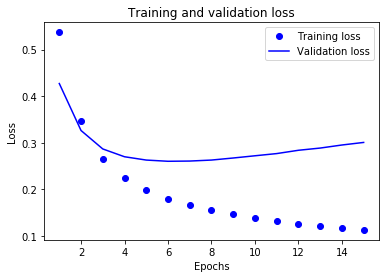

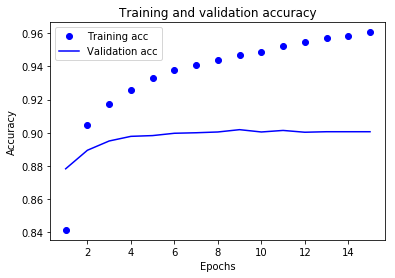

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

y_pred = model.predict(final_x_test)
y_true = final_y_test

print("sanity check")
print("{} inctences predicted".format(len(y_pred)))
print("{} inctences Exist".format(len(y_true)))

cm = confusion_matrix(y_true, y_pred.round())  #round

sanity check
6450 inctences predicted
6450 inctences Exist


In [18]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                         title="Confusion matrix",
                         cmap = plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/ cm.sum(axis=1)[:,np.newaxis]
        print("normalized Confusion Matrix")
    else:
        print("Confusion matrix without normalization")
    
    print(cm)
    
    thresh=cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel("True values")
    plt.xlabel("predicted values")
    

Confusion matrix without normalization
[[2934  297]
 [ 317 2902]]


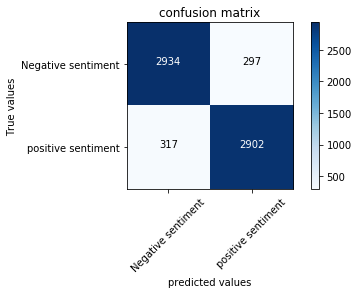

In [19]:
cm_plot_labels=['Negative sentiment','positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='confusion matrix')